# Procedure for estimating noise parameters

In [1]:
from __future__ import annotations

import numdifftools as nd
import numpy as np

from numpy.typing import ArrayLike
from scipy.optimize import minimize
from matplotlib import pyplot as plt
from matplotlib.figure import figaspect
from scipy.optimize import approx_fprime
from numpy.random import default_rng

import thztools as thz
from thztools import tdnll

## Simulate measurements
Simulate a set of `m` waveforms, each sampled at `n` time points, with noise parameters
`sigma_alpha`, `sigma_beta`, and `sigma_tau`, and store them in an array `x`. Note that
`x` stores the waveforms in row orientation, with shape `(m, n)`, because NumPy
broadcasting rules and FFT functions are simpler for arrays that are row-oriented.
Measurement waveforms are typically loaded from data files in column orientation,
however, so the `tdnoisefit` function assumes that the data array is column-oriented—this
may be worth changing in a future version.

In [2]:
rng = np.random.default_rng(0)
n = 256
m = 64
ts = 0.05
t = np.arange(n) * ts
mu, _ = thz.thzgen(n, ts=ts, t0=n * ts / 3)
sigma = np.array([1e-5, 1e-2, 1e-3])
noise = thz.noiseamp(sigma, mu, ts) * rng.standard_normal((m, n))
x = np.array(mu + noise)
a = np.ones(m)
eta = np.zeros(m)

## Fit for the noise parameters

Set the initial guesses `a0` and `eta0` for the amplitudes and delays, respectively, and
estimate the noise parameters from the simulated measurements. Note that we must take the
transpose of `x`, to convert it from row-orientation to column-orientation.

In [3]:
result = thz.tdnoisefit(
    x.T,
    v0=sigma**2,
    mu0=mu,
    a0=a,
    eta0=eta,
    ts=ts,
    fix_v=True,
    fix_mu=False,
    fix_a=True,
    fix_eta=True,
)

Optimization terminated successfully.
         Current function value: -147716.527328
         Iterations: 91
         Function evaluations: 162
         Gradient evaluations: 162


In [4]:
result_all_free = thz.tdnoisefit(x.T, ts=ts)

Optimization terminated successfully.
         Current function value: -116335.831606
         Iterations: 157
         Function evaluations: 242
         Gradient evaluations: 242


In [5]:
sigma_out = np.sqrt(result_all_free[0]["var"])
for val_in, val_out in zip(sigma, sigma_out):
    print(f"Input: {val_in:6.4g}\t Output: {val_out:6.4g}")

Input:  1e-05	 Output: 5.413e-05
Input:   0.01	 Output: 0.005961
Input:  0.001	 Output: 0.004566


## Plot the data

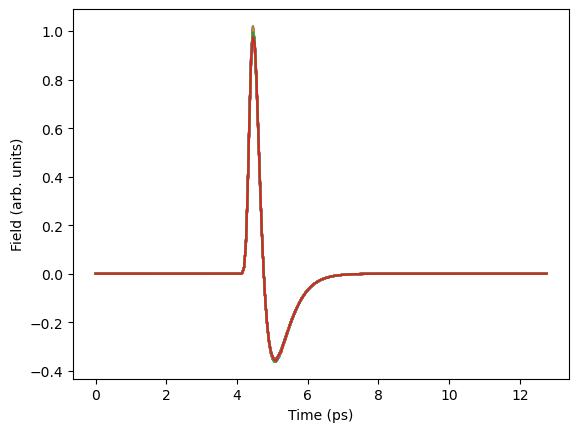

In [6]:
_, ax = plt.subplots()
ax.plot(t, x.T)
ax.set_xlabel('Time (ps)')
ax.set_ylabel('Field (arb. units)')
plt.show()

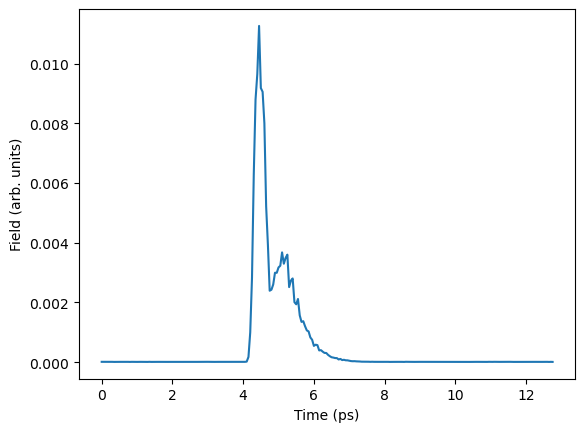

In [7]:
_, ax = plt.subplots()
ax.plot(t, np.std(x, axis=0).T)
ax.set_xlabel('Time (ps)')
ax.set_ylabel('Field (arb. units)')
plt.show()

## Consider alternative method
Try alternating between minimizing the least-squares portion of the cost function for fixed $\sigma$ and minimizing the log-likelihood as a function of $\sigma$ while holding all other parameters fixed.

## Check gradient calculation in tdnll

In [8]:
logv = np.log(sigma**2)
val, grad_mu_tdnll = tdnll(
    x,
    mu,
    logv,
    a,
    eta,
    ts,
    fix_logv=True,
    fix_mu=False,
    fix_a=True,
    fix_eta=True,
)

In [9]:
grad_mu_fprime = approx_fprime(
    mu,
    lambda _mu: tdnll(
        x,
        _mu,
        logv,
        a,
        eta,
        ts,
        fix_logv=True,
        fix_mu=True,
        fix_a=True,
        fix_eta=True,
    )[0],
    epsilon=1e-10,
)

In [10]:
grad_mu_tdnll

array([ 1.55708929e+06,  4.88661781e+05,  5.87287566e+05, -5.63994582e+05,
       -9.48484397e+05, -1.11423785e+06, -1.54137805e+06, -1.14154956e+06,
        2.91283579e+05, -3.42848351e+05,  8.32715288e+05, -5.84136730e+05,
       -1.09405807e+06, -5.36153270e+05, -1.79398811e+06, -1.65456739e+05,
        5.27988257e+05, -3.44634231e+04, -8.89878954e+05,  5.08611553e+05,
        5.55984833e+05, -8.85097218e+05, -1.38645450e+06,  2.99163478e+05,
       -1.41676123e+06,  2.08965975e+06,  1.40533874e+05,  1.05374326e+04,
       -6.32116569e+05, -3.35616675e+05,  6.08722390e+04, -7.67999494e+05,
        4.39766211e+05,  1.00697518e+06, -2.52042934e+05,  1.03071190e+05,
       -8.02639104e+05, -1.05235645e+06, -6.84200619e+05,  1.21247978e+06,
       -1.62849938e+05,  1.70708903e+05,  1.28508579e+06, -7.83626421e+05,
       -1.53949515e+06,  3.09969803e+05,  4.61465713e+04,  3.34672875e+05,
       -2.25447519e+05, -1.26245213e+06,  7.42530653e+04,  2.93740196e+04,
       -6.34052581e+05,  

In [11]:
grad_mu_fprime

array([ 1.55712129e+06,  4.88694641e+05,  5.87318500e+05, -5.63966169e+05,
       -9.48453962e+05, -1.11420726e+06, -1.54134672e+06, -1.14151539e+06,
        2.91314791e+05, -3.42817220e+05,  8.32749065e+05, -5.84102818e+05,
       -1.09402579e+06, -5.36123698e+05, -1.79395574e+06, -1.65425881e+05,
        5.28019445e+05, -3.44309956e+04, -8.89845833e+05,  5.08642697e+05,
        5.56017621e+05, -8.85063200e+05, -1.38642587e+06,  2.99195235e+05,
       -1.41673052e+06,  2.08968937e+06,  1.40568591e+05,  1.05687650e+04,
       -6.32086594e+05, -3.35586374e+05,  6.09035487e+04, -7.67966849e+05,
        4.39799333e+05,  1.00700650e+06, -2.52009777e+05,  1.03100610e+05,
       -8.02603900e+05, -1.05232350e+06, -6.84169936e+05,  1.21251156e+06,
       -1.62818178e+05,  1.70740532e+05,  1.28511630e+06, -7.83592986e+05,
       -1.53946370e+06,  3.09998286e+05,  4.61778836e+04,  3.34702490e+05,
       -2.25414697e+05, -1.26242405e+06,  7.42840348e+04,  2.94009806e+04,
       -6.34020253e+05,  

In [12]:
def tdnll_mu(_mu):
    return tdnll(
        x,
        _mu,
        logv,
        a,
        eta,
        ts,
        fix_logv=True,
        fix_mu=True,
        fix_a=True,
        fix_eta=True,
    )[0]

In [13]:
grad_mu_nd = nd.Gradient(tdnll_mu, step=1e-10)(mu)

In [14]:
grad_mu_nd

array([ 1.55708929e+06,  4.88660403e+05,  5.87288475e+05, -5.63994353e+05,
       -9.48485753e+05, -1.11424049e+06, -1.54137919e+06, -1.14154862e+06,
        2.91282607e+05, -3.42848479e+05,  8.32714217e+05, -5.84137549e+05,
       -1.09405815e+06, -5.36151739e+05, -1.79398921e+06, -1.65458318e+05,
        5.27987533e+05, -3.44621338e+04, -8.89879374e+05,  5.08611514e+05,
        5.55986434e+05, -8.85095141e+05, -1.38645733e+06,  2.99163487e+05,
       -1.41676300e+06,  2.08965776e+06,  1.40534382e+05,  1.05376230e+04,
       -6.32116664e+05, -3.35616177e+05,  6.08700743e+04, -7.67999382e+05,
        4.39766554e+05,  1.00697251e+06, -2.52041916e+05,  1.03070334e+05,
       -8.02637011e+05, -1.05235775e+06, -6.84201603e+05,  1.21248032e+06,
       -1.62850033e+05,  1.70708649e+05,  1.28508637e+06, -7.83626536e+05,
       -1.53949617e+06,  3.09967992e+05,  4.61445559e+04,  3.34670448e+05,
       -2.25447129e+05, -1.26245421e+06,  7.42508503e+04,  2.93727474e+04,
       -6.34053815e+05,  

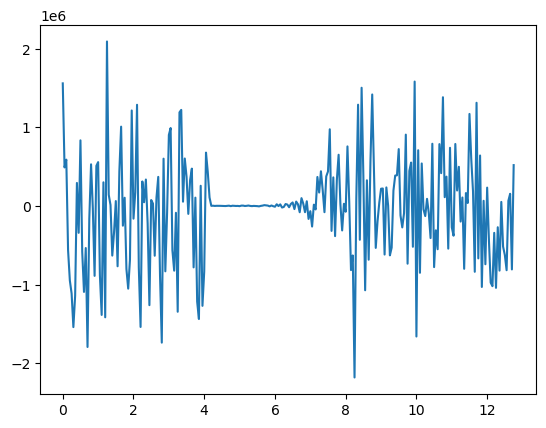

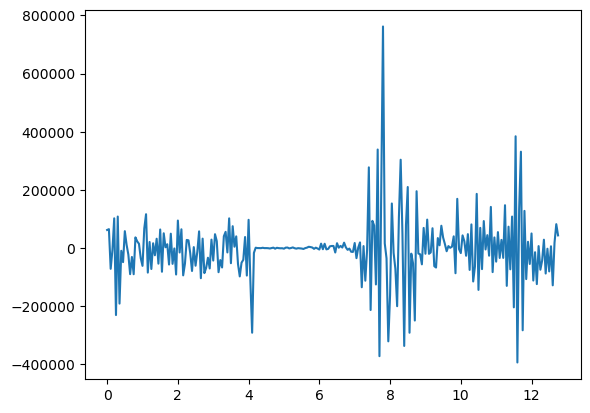

In [15]:
plt.plot(t, grad_mu_nd)
plt.show()
plt.plot(t, nd.Gradient(tdnll_mu, step=1e-10)(result[0]["mu"]))
plt.show()

In [16]:
result

({'var': array([1.e-10, 1.e-04, 1.e-06]),
  'mu': array([-2.26754294e-06, -7.31882194e-07, -9.57486869e-07,  7.97672375e-07,
          1.71801643e-06,  1.30322616e-06,  2.65765599e-06,  1.40338148e-06,
         -3.85232342e-07,  3.73876444e-07, -1.12192667e-06,  8.40098102e-07,
          1.76682653e-06,  6.02274219e-07,  2.85372338e-06,  1.75539994e-08,
         -6.64665004e-07, -1.53284875e-08,  1.52140909e-06, -9.59045216e-07,
         -8.51220347e-07,  1.37256309e-06,  2.46731777e-06, -7.20779935e-07,
          2.37098516e-06, -3.50476459e-06, -6.23738476e-08, -1.89795706e-07,
          1.17561911e-06,  2.99114948e-07,  1.49752665e-07,  9.24193960e-07,
         -4.55033006e-07, -1.72545283e-06,  5.74872998e-07, -4.13620647e-07,
          1.50018826e-06,  1.38587872e-06,  1.24540003e-06, -2.21941402e-06,
          5.90683064e-07, -4.84525158e-07, -1.70736449e-06,  8.72583858e-07,
          2.53342919e-06, -6.58201999e-07,  1.93918756e-07, -7.82772561e-07,
          4.67458307e-07,  1

In [17]:
val

-147612.11995440038

In [18]:
result2 = thz.tdnoisefit(
    x.T,
    v0=sigma**2,
    mu0=result[0]["mu"],
    a0=a,
    eta0=eta,
    ts=ts,
    fix_v=True,
    fix_mu=False,
    fix_a=True,
    fix_eta=True,
)

Optimization terminated successfully.
         Current function value: -147722.881539
         Iterations: 84
         Function evaluations: 148
         Gradient evaluations: 148


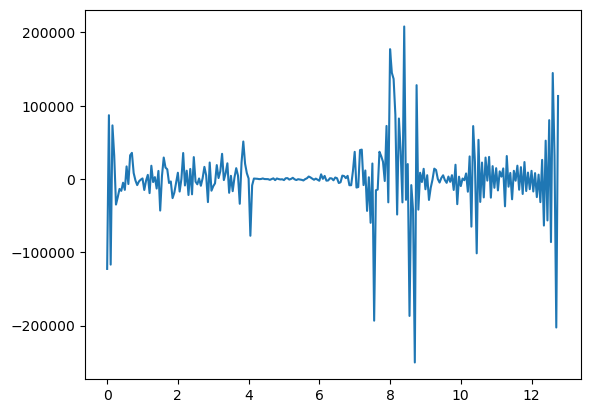

In [19]:
plt.plot(t, nd.Gradient(tdnll_mu, step=1e-10)(result2[0]["mu"]))
plt.show()

In [20]:
result3 = thz.tdnoisefit(
    x.T,
    v0=sigma**2,
    mu0=result2[0]["mu"],
    a0=a,
    eta0=eta,
    ts=ts,
    fix_v=True,
    fix_mu=False,
    fix_a=True,
    fix_eta=True,
)

Optimization terminated successfully.
         Current function value: -147724.566747
         Iterations: 84
         Function evaluations: 140
         Gradient evaluations: 140


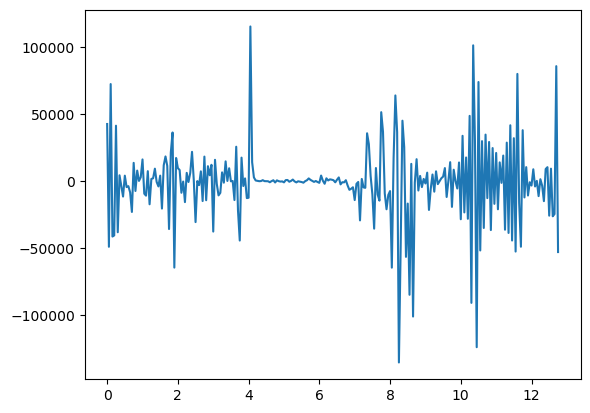

In [21]:
plt.plot(t, nd.Gradient(tdnll_mu, step=1e-10)(result3[0]["mu"]))
plt.show()

In [22]:
result4 = thz.tdnoisefit(
    x.T,
    v0=sigma**2,
    mu0=result3[0]["mu"],
    a0=a,
    eta0=eta,
    ts=ts,
    fix_v=True,
    fix_mu=False,
    fix_a=True,
    fix_eta=True,
)

Optimization terminated successfully.
         Current function value: -147725.257285
         Iterations: 84
         Function evaluations: 144
         Gradient evaluations: 144


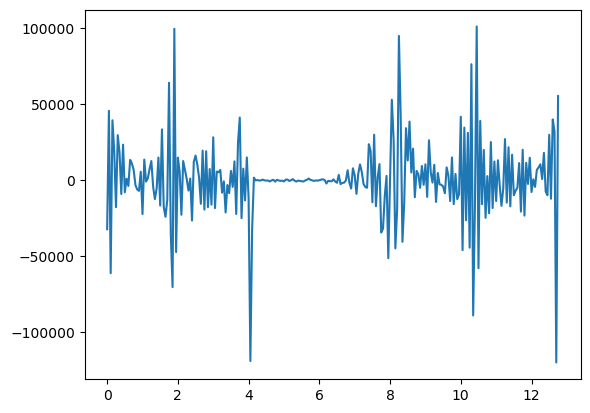

In [23]:
plt.plot(t, nd.Gradient(tdnll_mu, step=1e-10)(result4[0]["mu"]))
plt.show()

In [24]:
result5 = thz.tdnoisefit(
    x.T,
    v0=sigma**2,
    mu0=result4[0]["mu"],
    a0=a,
    eta0=eta,
    ts=ts,
    fix_v=True,
    fix_mu=False,
    fix_a=True,
    fix_eta=True,
)

Optimization terminated successfully.
         Current function value: -147725.654964
         Iterations: 82
         Function evaluations: 136
         Gradient evaluations: 136


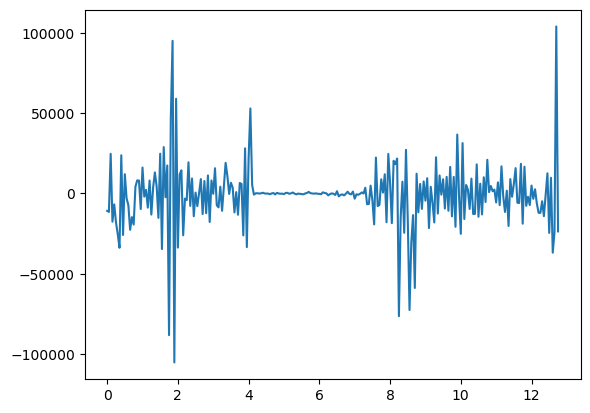

In [25]:
_, grad_mu = tdnll(
    x,
    result5[0]["mu"],
    logv,
    a,
    eta,
    ts,
    fix_logv=True,
    fix_mu=False,
    fix_a=True,
    fix_eta=True,
)
plt.plot(t, grad_mu)
plt.show()

In [26]:
result6 = thz.tdnoisefit(
    x.T,
    v0=sigma**2,
    mu0=result5[0]["mu"],
    a0=a,
    eta0=eta,
    ts=ts,
    fix_v=True,
    fix_mu=False,
    fix_a=True,
    fix_eta=True,
)

Optimization terminated successfully.
         Current function value: -147725.883130
         Iterations: 75
         Function evaluations: 108
         Gradient evaluations: 108


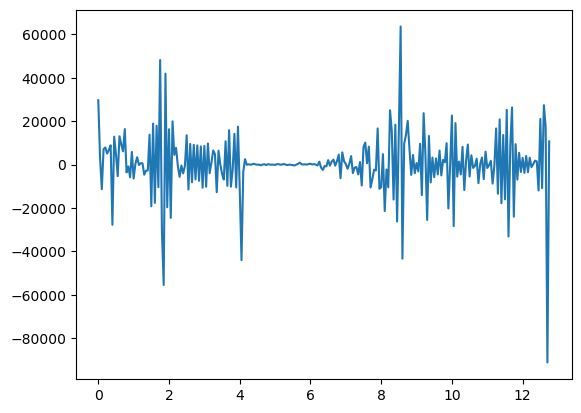

In [27]:
_, grad_mu = tdnll(
    x,
    result6[0]["mu"],
    logv,
    a,
    eta,
    ts,
    fix_logv=True,
    fix_mu=False,
    fix_a=True,
    fix_eta=True,
)
plt.plot(t, grad_mu)
plt.show()

In [28]:
result7 = thz.tdnoisefit(
    x.T,
    v0=sigma**2,
    mu0=result6[0]["mu"],
    a0=a,
    eta0=eta,
    ts=ts,
    fix_v=True,
    fix_mu=False,
    fix_a=True,
    fix_eta=True,
)

Optimization terminated successfully.
         Current function value: -147726.039854
         Iterations: 84
         Function evaluations: 153
         Gradient evaluations: 153


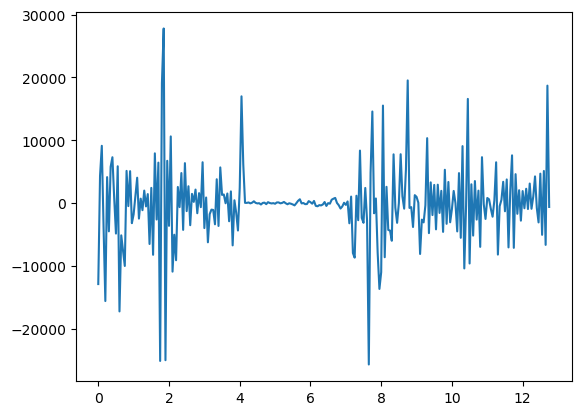

In [29]:
_, grad_mu = tdnll(
    x,
    result7[0]["mu"],
    logv,
    a,
    eta,
    ts,
    fix_logv=True,
    fix_mu=False,
    fix_a=True,
    fix_eta=True,
)
plt.plot(t, grad_mu)
plt.show()

Optimization terminated successfully.
         Current function value: -147726.085787
         Iterations: 75
         Function evaluations: 122
         Gradient evaluations: 122


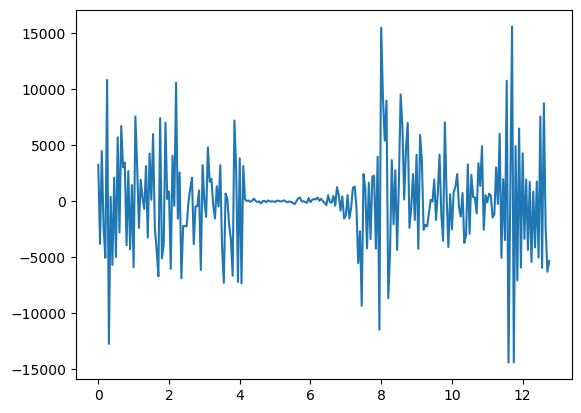

In [30]:
result8 = thz.tdnoisefit(
    x.T,
    v0=sigma**2,
    mu0=result7[0]["mu"],
    a0=a,
    eta0=eta,
    ts=ts,
    fix_v=True,
    fix_mu=False,
    fix_a=True,
    fix_eta=True,
)
_, grad_mu = tdnll(
    x,
    result8[0]["mu"],
    logv,
    a,
    eta,
    ts,
    fix_logv=True,
    fix_mu=False,
    fix_a=True,
    fix_eta=True,
)
plt.plot(t, grad_mu)
plt.show()

Optimization terminated successfully.
         Current function value: -147726.089648
         Iterations: 3
         Function evaluations: 8
         Gradient evaluations: 8


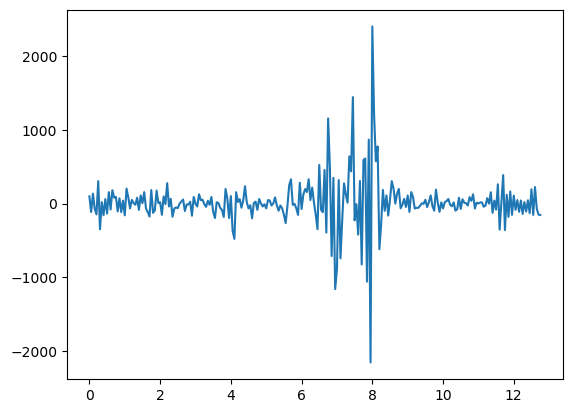

In [31]:
result9 = thz.tdnoisefit(
    x.T,
    v0=sigma**2,
    mu0=result8[0]["mu"],
    a0=a,
    eta0=eta,
    ts=ts,
    fix_v=True,
    fix_mu=False,
    fix_a=True,
    fix_eta=True,
)
_, grad_mu = tdnll(
    x,
    result9[0]["mu"],
    logv,
    a,
    eta,
    ts,
    fix_logv=True,
    fix_mu=False,
    fix_a=True,
    fix_eta=True,
)
plt.plot(t, grad_mu)
plt.show()

Optimization terminated successfully.
         Current function value: -147726.089682
         Iterations: 1
         Function evaluations: 4
         Gradient evaluations: 4


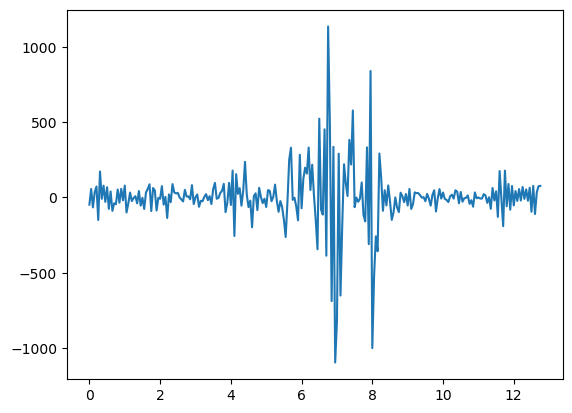

In [32]:
result10 = thz.tdnoisefit(
    x.T,
    v0=sigma**2,
    mu0=result9[0]["mu"],
    a0=a,
    eta0=eta,
    ts=ts,
    fix_v=True,
    fix_mu=False,
    fix_a=True,
    fix_eta=True,
)
_, grad_mu = tdnll(
    x,
    result10[0]["mu"],
    logv,
    a,
    eta,
    ts,
    fix_logv=True,
    fix_mu=False,
    fix_a=True,
    fix_eta=True,
)
plt.plot(t, grad_mu)
plt.show()

Optimization terminated successfully.
         Current function value: -147726.089705
         Iterations: 1
         Function evaluations: 4
         Gradient evaluations: 4


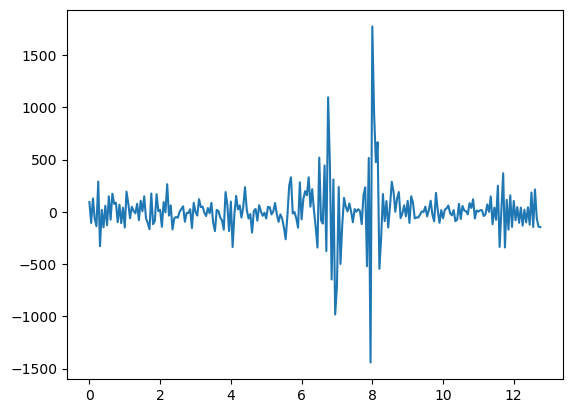

In [33]:
result11 = thz.tdnoisefit(
    x.T,
    v0=sigma**2,
    mu0=result10[0]["mu"],
    a0=a,
    eta0=eta,
    ts=ts,
    fix_v=True,
    fix_mu=False,
    fix_a=True,
    fix_eta=True,
)
_, grad_mu = tdnll(
    x,
    result11[0]["mu"],
    logv,
    a,
    eta,
    ts,
    fix_logv=True,
    fix_mu=False,
    fix_a=True,
    fix_eta=True,
)
plt.plot(t, grad_mu)
plt.show()

Optimization terminated successfully.
         Current function value: -147726.089724
         Iterations: 1
         Function evaluations: 4
         Gradient evaluations: 4


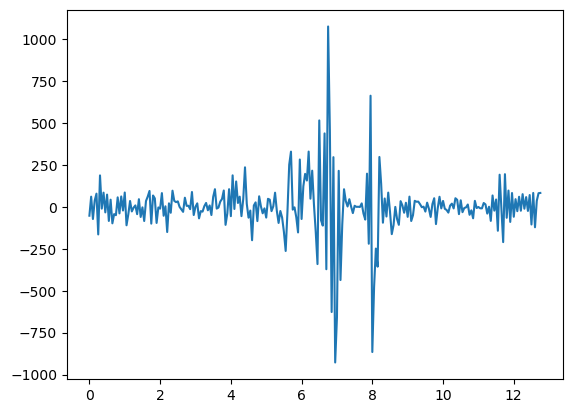

In [34]:
result12 = thz.tdnoisefit(
    x.T,
    v0=sigma**2,
    mu0=result11[0]["mu"],
    a0=a,
    eta0=eta,
    ts=ts,
    fix_v=True,
    fix_mu=False,
    fix_a=True,
    fix_eta=True,
)
_, grad_mu = tdnll(
    x,
    result12[0]["mu"],
    logv,
    a,
    eta,
    ts,
    fix_logv=True,
    fix_mu=False,
    fix_a=True,
    fix_eta=True,
)
plt.plot(t, grad_mu)
plt.show()

Optimization terminated successfully.
         Current function value: -147726.089741
         Iterations: 1
         Function evaluations: 4
         Gradient evaluations: 4


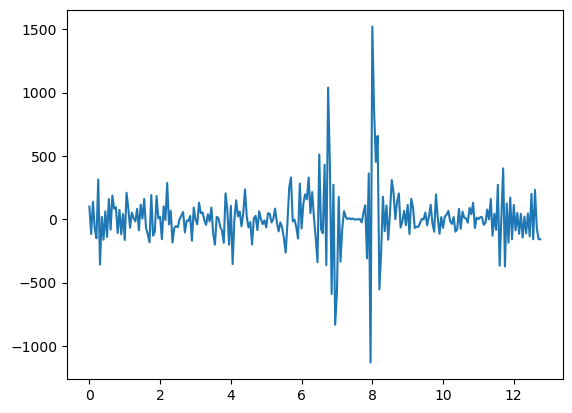

In [35]:
result13 = thz.tdnoisefit(
    x.T,
    v0=sigma**2,
    mu0=result12[0]["mu"],
    a0=a,
    eta0=eta,
    ts=ts,
    fix_v=True,
    fix_mu=False,
    fix_a=True,
    fix_eta=True,
)
_, grad_mu = tdnll(
    x,
    result13[0]["mu"],
    logv,
    a,
    eta,
    ts,
    fix_logv=True,
    fix_mu=False,
    fix_a=True,
    fix_eta=True,
)
plt.plot(t, grad_mu)
plt.show()

Optimization terminated successfully.
         Current function value: -147726.089756
         Iterations: 1
         Function evaluations: 4
         Gradient evaluations: 4


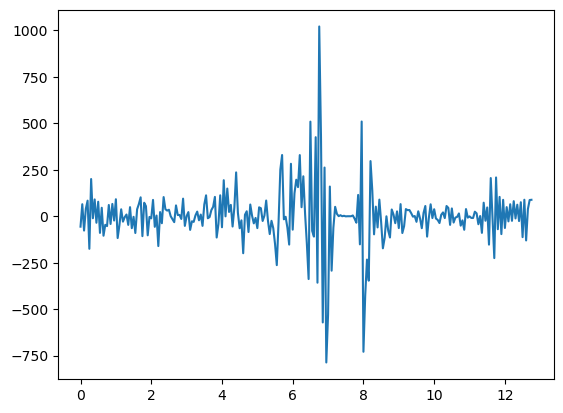

In [36]:
result14 = thz.tdnoisefit(
    x.T,
    v0=sigma**2,
    mu0=result13[0]["mu"],
    a0=a,
    eta0=eta,
    ts=ts,
    fix_v=True,
    fix_mu=False,
    fix_a=True,
    fix_eta=True,
)
_, grad_mu = tdnll(
    x,
    result14[0]["mu"],
    logv,
    a,
    eta,
    ts,
    fix_logv=True,
    fix_mu=False,
    fix_a=True,
    fix_eta=True,
)
plt.plot(t, grad_mu)
plt.show()

Optimization terminated successfully.
         Current function value: -147726.089771
         Iterations: 1
         Function evaluations: 4
         Gradient evaluations: 4


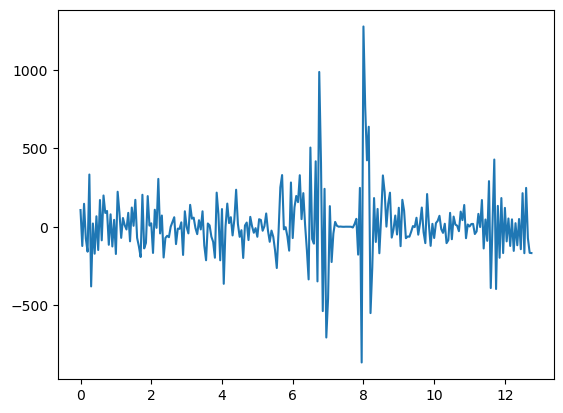

In [37]:
result15 = thz.tdnoisefit(
    x.T,
    v0=sigma**2,
    mu0=result14[0]["mu"],
    a0=a,
    eta0=eta,
    ts=ts,
    fix_v=True,
    fix_mu=False,
    fix_a=True,
    fix_eta=True,
)
_, grad_mu = tdnll(
    x,
    result15[0]["mu"],
    logv,
    a,
    eta,
    ts,
    fix_logv=True,
    fix_mu=False,
    fix_a=True,
    fix_eta=True,
)
plt.plot(t, grad_mu)
plt.show()

Optimization terminated successfully.
         Current function value: -147726.089784
         Iterations: 1
         Function evaluations: 4
         Gradient evaluations: 4


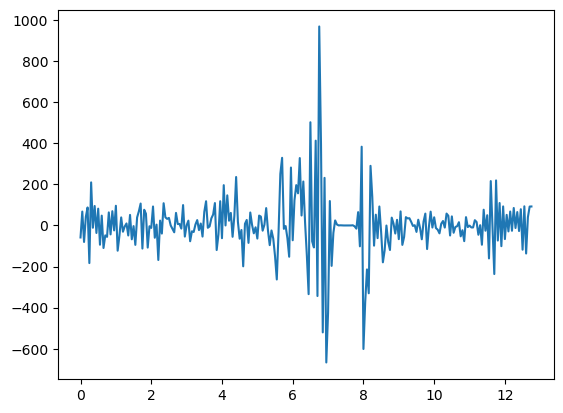

In [38]:
result16 = thz.tdnoisefit(
    x.T,
    v0=sigma**2,
    mu0=result15[0]["mu"],
    a0=a,
    eta0=eta,
    ts=ts,
    fix_v=True,
    fix_mu=False,
    fix_a=True,
    fix_eta=True,
)
_, grad_mu = tdnll(
    x,
    result16[0]["mu"],
    logv,
    a,
    eta,
    ts,
    fix_logv=True,
    fix_mu=False,
    fix_a=True,
    fix_eta=True,
)
plt.plot(t, grad_mu)
plt.show()

Optimization terminated successfully.
         Current function value: -147726.089796
         Iterations: 1
         Function evaluations: 4
         Gradient evaluations: 4


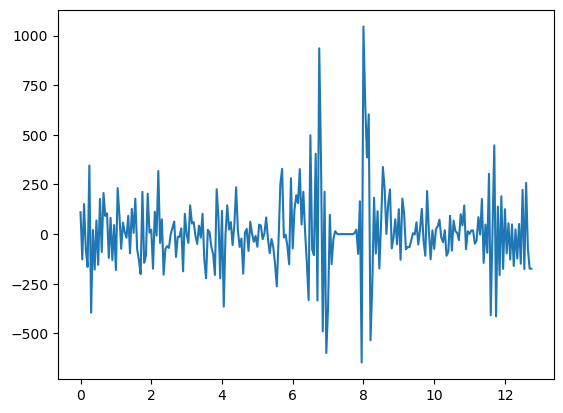

In [39]:
result17 = thz.tdnoisefit(
    x.T,
    v0=sigma**2,
    mu0=result16[0]["mu"],
    a0=a,
    eta0=eta,
    ts=ts,
    fix_v=True,
    fix_mu=False,
    fix_a=True,
    fix_eta=True,
)
_, grad_mu = tdnll(
    x,
    result17[0]["mu"],
    logv,
    a,
    eta,
    ts,
    fix_logv=True,
    fix_mu=False,
    fix_a=True,
    fix_eta=True,
)
plt.plot(t, grad_mu)
plt.show()

Optimization terminated successfully.
         Current function value: -147726.089808
         Iterations: 1
         Function evaluations: 4
         Gradient evaluations: 4


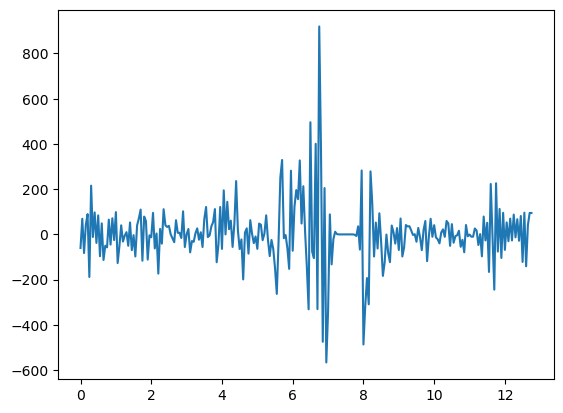

In [40]:
result18 = thz.tdnoisefit(
    x.T,
    v0=sigma**2,
    mu0=result17[0]["mu"],
    a0=a,
    eta0=eta,
    ts=ts,
    fix_v=True,
    fix_mu=False,
    fix_a=True,
    fix_eta=True,
)
_, grad_mu = tdnll(
    x,
    result18[0]["mu"],
    logv,
    a,
    eta,
    ts,
    fix_logv=True,
    fix_mu=False,
    fix_a=True,
    fix_eta=True,
)
plt.plot(t, grad_mu)
plt.show()

Optimization terminated successfully.
         Current function value: -147726.089818
         Iterations: 1
         Function evaluations: 4
         Gradient evaluations: 4


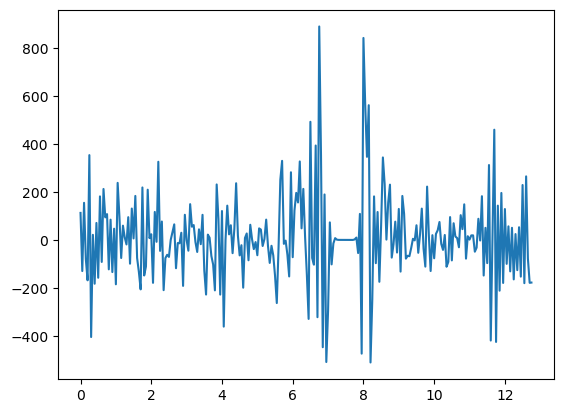

In [41]:
result19 = thz.tdnoisefit(
    x.T,
    v0=sigma**2,
    mu0=result18[0]["mu"],
    a0=a,
    eta0=eta,
    ts=ts,
    fix_v=True,
    fix_mu=False,
    fix_a=True,
    fix_eta=True,
)
_, grad_mu = tdnll(
    x,
    result19[0]["mu"],
    logv,
    a,
    eta,
    ts,
    fix_logv=True,
    fix_mu=False,
    fix_a=True,
    fix_eta=True,
)
plt.plot(t, grad_mu)
plt.show()

Optimization terminated successfully.
         Current function value: -147726.089829
         Iterations: 1
         Function evaluations: 4
         Gradient evaluations: 4


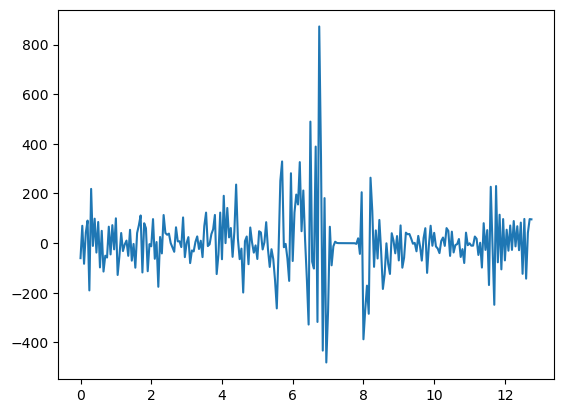

In [42]:
result20 = thz.tdnoisefit(
    x.T,
    v0=sigma**2,
    mu0=result19[0]["mu"],
    a0=a,
    eta0=eta,
    ts=ts,
    fix_v=True,
    fix_mu=False,
    fix_a=True,
    fix_eta=True,
)
_, grad_mu = tdnll(
    x,
    result20[0]["mu"],
    logv,
    a,
    eta,
    ts,
    fix_logv=True,
    fix_mu=False,
    fix_a=True,
    fix_eta=True,
)
plt.plot(t, grad_mu)
plt.show()

Optimization terminated successfully.
         Current function value: -147726.089838
         Iterations: 1
         Function evaluations: 4
         Gradient evaluations: 4


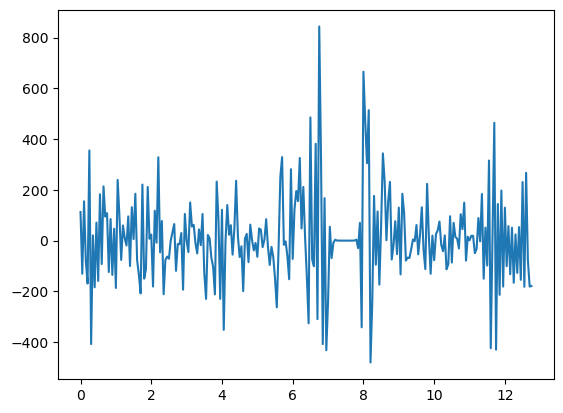

In [43]:
result21 = thz.tdnoisefit(
    x.T,
    v0=sigma**2,
    mu0=result20[0]["mu"],
    a0=a,
    eta0=eta,
    ts=ts,
    fix_v=True,
    fix_mu=False,
    fix_a=True,
    fix_eta=True,
)
_, grad_mu = tdnll(
    x,
    result21[0]["mu"],
    logv,
    a,
    eta,
    ts,
    fix_logv=True,
    fix_mu=False,
    fix_a=True,
    fix_eta=True,
)
plt.plot(t, grad_mu)
plt.show()

Optimization terminated successfully.
         Current function value: -147726.089848
         Iterations: 1
         Function evaluations: 4
         Gradient evaluations: 4


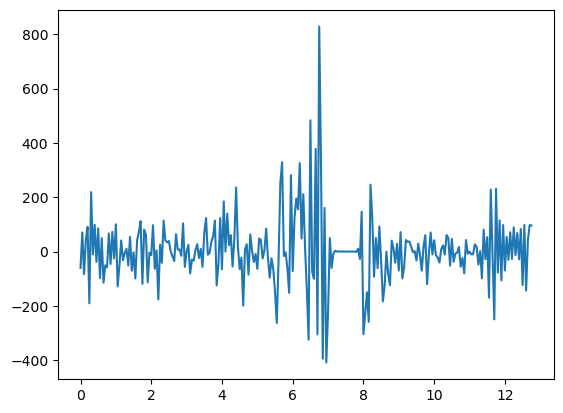

In [44]:
result22 = thz.tdnoisefit(
    x.T,
    v0=sigma**2,
    mu0=result21[0]["mu"],
    a0=a,
    eta0=eta,
    ts=ts,
    fix_v=True,
    fix_mu=False,
    fix_a=True,
    fix_eta=True,
)
_, grad_mu = tdnll(
    x,
    result22[0]["mu"],
    logv,
    a,
    eta,
    ts,
    fix_logv=True,
    fix_mu=False,
    fix_a=True,
    fix_eta=True,
)
plt.plot(t, grad_mu)
plt.show()

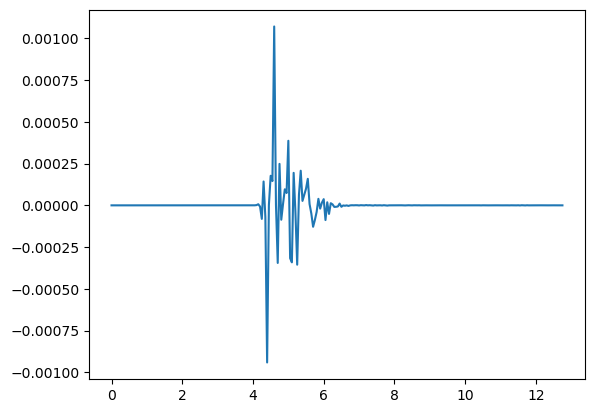

In [45]:
plt.plot(t, result20[0]["mu"] - result[0]["mu"])
plt.show()